In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import folium
from geocoding import geocode
import numpy as np

200
{
  "type": "FeatureCollection",
  "features": [],
  "attribution": "NOTICE: \u00a9 2024 Mapbox and its suppliers. All rights reserved. Use of this data is subject to the Mapbox Terms of Service (https://www.mapbox.com/about/maps/). This response and the information it contains may not be retained."
}
None


In [14]:
gdf = gpd.read_file('City Wards Data.geojson')

Checking to see if the file loaded into the dataframe properly

<AxesSubplot:>

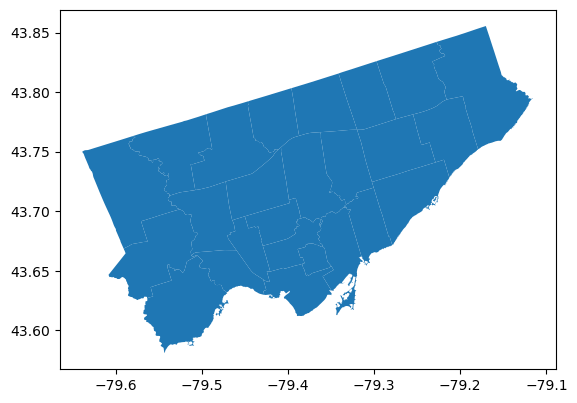

In [5]:
gdf.plot()

Loading data samples into dataframes and creating columns for the address

In [7]:
#lets read our sample dataset
transportation_sample = "transporation_sample.csv"
transportation_df = pd.read_csv(transportation_sample)

#handling the null values for postal codes
transportation_df['Postal'] = transportation_df['Postal'].replace(r'^\s*$', '###', regex=True)

#creating new column
transportation_df['Address'] = transportation_df['Street_Num'] + " " +transportation_df['Street_Name'] + " "+ transportation_df['Street_Type'] +" " + transportation_df['Street_Direction'] + " " + transportation_df["Postal"]

print(transportation_df.head())

In [36]:
real_estate_df = pd.read_csv('realestate_sample.csv')

#handling the null values for postal codes
real_estate_df['Postal'] = transportation_df['Postal'].replace(r'^\s*$', '###', regex=True)

#creating new column
real_estate_df['Address'] = real_estate_df['Street_Num'] + " " +real_estate_df['Street_Name'] + " "+ real_estate_df['Street_Type'] +" " + real_estate_df['Street_Direction'] + real_estate_df['Postal']

print(real_estate_df.head())


In [3]:
amenities_df = pd.read_csv('amenities_sample.csv')

#handling the null values for postal codes
amenities_df['Postal'] = amenities_df['Postal'].replace(r'^\s*$', '###', regex=True)

#creating new column
amenities_df['Address'] = amenities_df['Street_Num'] + " " +amenities_df['Street_Name'] + " "+ amenities_df['Street_Type'] +" " + amenities_df['Street_Direction'] + amenities_df['Postal']

print(amenities_df.head())

In [ ]:
demolition_df = pd.read_csv("DemolitionDimension_Sample.csv")

print(demolition_df.head())

Turning Full Addresses into Coordinates using our geocoder

In [85]:
#coordinate extraction
from tqdm.notebook import tqdm  #progress bar
tqdm.pandas()
transportation_df[
    'Coordinates'] = transportation_df['Address'].progress_apply(lambda x: geocode(x))
print(transportation_df.head())

  0%|          | 0/379 [00:00<?, ?it/s]

200
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "id": "dXJuOm1ieGFkcjpmYjRhMzNkMC02MTIwLTQ3ODAtODU3NC0xNTc4NjM2MjIwNjY",
      "geometry": {
        "type": "Point",
        "coordinates": [
          -79.449097,
          43.725178
        ]
      },
      "properties": {
        "mapbox_id": "dXJuOm1ieGFkcjpmYjRhMzNkMC02MTIwLTQ3ODAtODU3NC0xNTc4NjM2MjIwNjY",
        "feature_type": "address",
        "full_address": "1 Yorkdale Road, North York, Ontario M6A 3A1, Canada",
        "name": "1 Yorkdale Road",
        "coordinates": {
          "longitude": -79.449097,
          "latitude": 43.725178,
          "accuracy": "rooftop",
          "routable_points": [
            {
              "name": "default",
              "latitude": 43.725002222778386,
              "longitude": -79.44893034253352
            }
          ]
        },
        "place_formatted": "North York, Ontario M6A 3A1, Canada",
        "match_code": {
          "address_numb

UnboundLocalError: local variable 'lat' referenced before assignment

In [30]:
tqdm.pandas()
amenities_df[
    'Coordinates'] = amenities_df['Address'].progress_apply(lambda x: geocode(x))
print(amenities_df.head())

In [33]:
tqdm.pandas()
real_estate_df[
    'Coordinates'] = real_estate_df['Address'].progress_apply(lambda x: geocode(x))
print(real_estate_df['Coordinates'])

      Permit_Num                      Permit_Type  \
0  00 330311 CMB  Non-Residential Building Permit   
1  02 151529 BLD   Building Additions/Alterations   
2  04 111348 BLD   Building Additions/Alterations   
3  04 198435 BLD   Building Additions/Alterations   
4  05 115473 BLD                     New Building   

                 Structure_Type                                      Work  \
0  Hair, Barber and Other Salon  Addition/Alteration to Existing Building   
1                        Museum                      Interior Alterations   
2        Performing Arts Centre                      Interior Alterations   
3                Fitness Centre                      Interior Alterations   
4                          Club                              New Building   

  Street_Num   Street_Name Street_Type Street_Direction Postal      Geo_Id  \
0       3360         YONGE          ST                     M4N   7793316.0   
1        100      GARRISON          RD                     M5V

In [ ]:
tqdm.pandas()
demolition_df[
    'Coordinates'] = demolition_df['IBMS Address'].progress_apply(lambda x: geocode(x))
print(real_estate_df['Coordinates'])

MAPPING SECTION -- taking our points and linking them to a ward

In [ ]:
#getting our map ready. we need to project the initial GeoJSON onto the folium map
gdf_projected = gdf.to_crs(epsg=4326)
s_index = gdf_projected.sindex
centroid = gdf_projected.geometry.centroid

In [15]:
mean_latitude = centroid.y.mean()
mean_longitude = centroid.x.mean()

/var/folders/73/svsm8vw94tzb_w86qcpwfh2h0000gn/T/ipykernel_82945/1260398762.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf_projected.geometry.centroid


In [16]:
m = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10)

In [17]:
#ward mapping function
def ward_mapper(point):
    ward_index = None
    ward_name = None

    if point is not None:
        possible_matches_index = list(s_index.intersection(point.bounds)) #list of possible wards
        found_match = False
        for idx in possible_matches_index: #iterate to find wards
            if gdf['geometry'][idx].contains(point):
                print("Point is contained within geometry at index:", idx)
                # Optionally, you can also print more information about the geometry
                print(gdf.iloc[idx]['AREA_NAME'])
                found_match = True
                ward_name = gdf.iloc[idx]['AREA_NAME']
                ward_index = idx

                break

        if not found_match:
            print(f"Point {point} is not contained in any ward.")
        latitude, longitude = point.y, point.x
        folium.Marker(location=(latitude, longitude), popup='Point').add_to(m)
    return ward_index,ward_name


In [18]:
folium.GeoJson(gdf_projected.to_json()).add_to(m)

In [20]:
# Unpack the result into separate columns in the DataFrame
transportation_df['Ward_Index'], transportation_df['Ward'] = zip(*transportation_df['Coordinates'].apply(ward_mapper))
print(transportation_df.loc[:, ['Coordinates','Ward_Index', 'Ward']])

Point is contained within geometry at index: 17
Eglinton-Lawrence
Point is contained within geometry at index: 3
University-Rosedale
Point is contained within geometry at index: 5
Scarborough Southwest
Point is contained within geometry at index: 23
Toronto-Danforth
Point is contained within geometry at index: 24
Spadina-Fort York
Point is contained within geometry at index: 24
Spadina-Fort York
Point is contained within geometry at index: 12
Toronto-St. Paul's
Point is contained within geometry at index: 5
Scarborough Southwest
Point is contained within geometry at index: 24
Spadina-Fort York
Point is contained within geometry at index: 24
Spadina-Fort York
Point is contained within geometry at index: 24
Spadina-Fort York
Point is contained within geometry at index: 4
Beaches-East York
Point is contained within geometry at index: 24
Spadina-Fort York
Point is contained within geometry at index: 12
Toronto-St. Paul's
Point is contained within geometry at index: 12
Toronto-St. Paul's
Po

In [22]:
amenities_df['Ward_Index'], amenities_df['Ward'] = zip(*amenities_df['Coordinates'].apply(ward_mapper))
print(amenities_df.loc[:, ['Coordinates','Ward_Index', 'Ward']])

                      Coordinates  Ward_Index                   Ward
0    POINT (-79.449097 43.725178)        17.0      Eglinton-Lawrence
1    POINT (-79.387611 43.670093)         3.0    University-Rosedale
2    POINT (-79.291077 43.720319)         5.0  Scarborough Southwest
3     POINT (-79.352537 43.67824)        23.0       Toronto-Danforth
4     POINT (-79.37923 43.645761)        24.0      Spadina-Fort York
..                            ...         ...                    ...
374  POINT (-79.358995 43.809934)        18.0       Don Valley North
375  POINT (-79.398964 43.705331)        12.0     Toronto-St. Paul's
376  POINT (-79.404371 43.667177)         3.0    University-Rosedale
377  POINT (-79.301503 43.689087)         4.0      Beaches-East York
378   POINT (-79.384452 43.64427)        24.0      Spadina-Fort York

[379 rows x 3 columns]


In [ ]:
real_estate_df['Ward_Index'], real_estate_df['Ward'] = zip(*real_estate_df['Coordinates'].apply(ward_mapper))
print(real_estate_df.loc[:, ['Coordinates','Ward_Index', 'Ward']])

In [ ]:
demolition_df['Ward_Index'], demolition_df['Ward'] = zip(*demolition_df['Coordinates'].apply(ward_mapper))
print(demolition_df.loc[:, ['Coordinates','Ward_Index', 'Ward']])

In [1]:
m # to view the points on the map

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/serenaiyoha/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/73/svsm8vw94tzb_w86qcpwfh2h0000gn/T/ipykernel_88558/1497821502.py", line 1, in <module>
    m
NameError: name 'm' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/serenaiyoha/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/serenaiyoha/Library/Python/3.10/lib/python/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/Users/serenaiyoha/Library/Python/3.10/lib/python/site-packages/IPython/core/ultratb.py", line 1012, in structured_traceback
    return VerboseTB.structur